In [3]:
import time
import requests
import numpy as np
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import datetime, timedelta
import matplotlib.pyplot as plt



USERNAME = "1iremtaslii@gmail.com"
PASSWORD = "GX!_2ynUK8Y-GL"

TGT = None
TGT_OBTAIN_TIME = None

def get_tgt():
    global TGT,TGT_OBTAIN_TIME
    url="https://giris.epias.com.tr/cas/v1/tickets"
    resp=requests.post(url,data={"username":USERNAME,"password":PASSWORD},allow_redirects=False)
    if resp.status_code==201:
        TGT=resp.headers["location"].split("/")[-1]
        TGT_OBTAIN_TIME=time.time()
        print("TGT alındı")
    else:
        raise RuntimeError(f"TGT alınamadı:{resp.status_code}")

def ensure_tgt():
    if TGT is None or (time.time()-TGT_OBTAIN_TIME>6840):
        get_tgt()
def fetch_interim_mcp(day):
    ensure_tgt()
    url="https://seffaflik.epias.com.tr/electricity-service/v1/markets/dam/data/mcp"
    headers={"TGT":TGT,"Content-Type":"application/json"}

    start_iso = f"{day}T00:00:00+03:00"
    end_iso   = f"{day}T23:00:00+03:00"

    body={
        "startDate":start_iso,
        "endDate":end_iso}
    resp = requests.post(url, headers=headers, json=body)
    try:
        resp_json = resp.json()
        if "items" in resp_json:
            df = pd.DataFrame(resp_json["items"])
            df["timestamp"] = pd.to_datetime(df["date"])
            return df[["timestamp", "price"]]
        else:
            return pd.DataFrame()
    except Exception as e:
        print("JSON parse hatası:", e)
        return pd.DataFrame()
        
end_date = datetime.utcnow().date()
start_date = end_date - timedelta(days=90)

get_tgt()

dfs=[]
current=start_date
while current<=end_date:
    day_str=current.strftime("%Y-%m-%d")
    try:
        df_day=fetch_interim_mcp(day_str)
        if not df_day.empty:
            dfs.append(df_day)
            print(f"Got datas:{day_str},{df_day.shape[0]} satır")
        else:
            print(f"No datas:{day_str}")
    except Exception as e:
        print(f"Error:{day_str}->{e}")
    current+=timedelta(days=1)
    time.sleep(1)


df_all=pd.concat(dfs,ignore_index=True)
df_all=df_all.sort_values("timestamp").set_index("timestamp")
df_all.to_csv("mcp_last3months.csv")

print("Saved last 3 months mcp datas:", df_all.shape)
        
        
                                  
    

TGT alındı
Got datas:2025-06-07,24 satır
Got datas:2025-06-08,24 satır
Got datas:2025-06-09,24 satır
Got datas:2025-06-10,24 satır
Got datas:2025-06-11,24 satır
Got datas:2025-06-12,24 satır
Got datas:2025-06-13,24 satır
Got datas:2025-06-14,24 satır
Got datas:2025-06-15,24 satır
Got datas:2025-06-16,24 satır
Got datas:2025-06-17,24 satır
Got datas:2025-06-18,24 satır
Got datas:2025-06-19,24 satır
Got datas:2025-06-20,24 satır
Got datas:2025-06-21,24 satır
Got datas:2025-06-22,24 satır
Got datas:2025-06-23,24 satır
Got datas:2025-06-24,24 satır
Got datas:2025-06-25,24 satır
Got datas:2025-06-26,24 satır
Got datas:2025-06-27,24 satır
Got datas:2025-06-28,24 satır
Got datas:2025-06-29,24 satır
Got datas:2025-06-30,24 satır
Got datas:2025-07-01,24 satır
Got datas:2025-07-02,24 satır
Got datas:2025-07-03,24 satır
Got datas:2025-07-04,24 satır
Got datas:2025-07-05,24 satır
Got datas:2025-07-06,24 satır
Got datas:2025-07-07,24 satır
Got datas:2025-07-08,24 satır
Got datas:2025-07-09,24 satır

train datas: (2160, 1)
real datas: (24, 1)


C:\Users\iremt\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
C:\Users\iremt\AppData\Roaming\Python\Python310\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


                              Real     Forecast
timestamp                                      
2025-09-05 00:00:00+03:00  3298.02  3345.977948
2025-09-05 01:00:00+03:00  3190.00  3303.391278
2025-09-05 02:00:00+03:00  2880.01  3209.114102
2025-09-05 03:00:00+03:00  3048.99  3097.024859
2025-09-05 04:00:00+03:00  2999.98  2952.158697
2025-09-05 05:00:00+03:00  2999.99  3048.637554
2025-09-05 06:00:00+03:00  2999.99  2984.174008
2025-09-05 07:00:00+03:00  2900.26  2763.197155
2025-09-05 08:00:00+03:00  3267.95  3082.817079
2025-09-05 09:00:00+03:00  3267.95  2926.616099
MAPE(%): 4.8


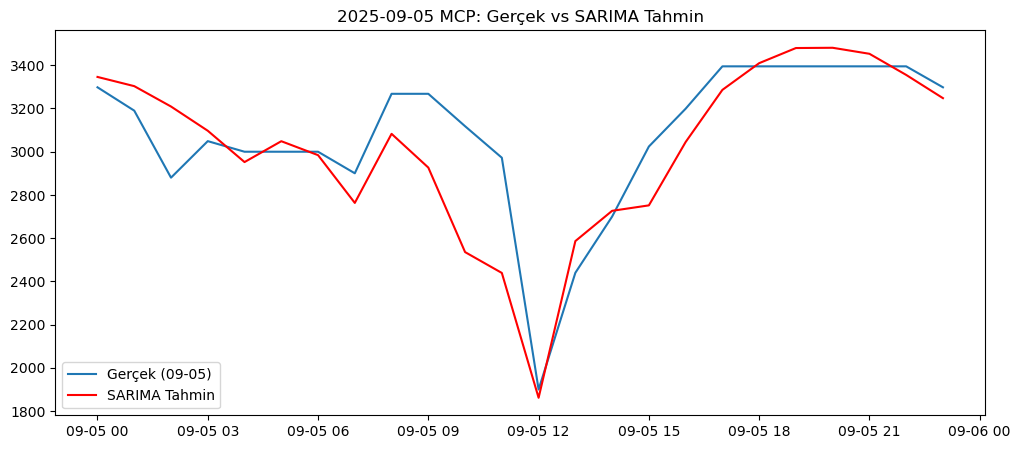

In [1]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

df2 = pd.read_csv("C:/Users/iremt/1AAnew/mcp_last3months.csv",parse_dates=["timestamp"], index_col="timestamp")
df_real=df2.loc["2025-09-05"]
df_train=df2.loc[:"2025-09-04"]

print ("train datas:",df_train.shape)
print("real datas:",df_real.shape)

model=SARIMAX(df_train["price"],order=(2,1,2),seasonal_order=(1,1,1,24))
model_fit=model.fit(disp=False)

forecast=model_fit.forecast(steps=24)
forecast.index=df_real.index

comparision=pd.DataFrame({"Real":df_real["price"],"Forecast":forecast})
print(comparision.head(10))

import numpy as np
mape=np.mean(np.abs((df_real["price"]-forecast)/df_real["price"]))*100
print("MAPE(%):",round(mape,2))

plt.figure(figsize=(12,5))
plt.plot(df_real.index, df_real["price"], label="Gerçek (09-05)")
plt.plot(forecast.index, forecast, label="SARIMA Tahmin", color="red")
plt.legend()
plt.title("2025-09-05 MCP: Gerçek vs SARIMA Tahmin")
plt.show()